# Subtracting Galactic Signal

pygdsm requires installation from source code here: https://github.com/telegraphic/pygdsm.

The best machine to do this runs Unix Operating system. Installation on Windows requires WSL (windows subsystem linux).

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import pygdsm
import healpy as hp
import pathlib

# healpy variables
n_side = 256
n_pix = hp.nside2npix(n_side)
# Solid angle of each pixel
omega = hp.nside2pixarea(n_side)  # in steradians

from astropy.time import Time
import astropy.units as u
from astropy.coordinates import EarthLocation, AltAz, SkyCoord

# Adak Island location
test_site_latitude = 51.8
test_site_longitude = -176.6
test_site_elevation_meters = 5 # meters

test_site_location = EarthLocation(
    lat=test_site_latitude * u.deg,
    lon=test_site_longitude * u.deg,
    height=test_site_elevation_meters * u.m
)

In [2]:
import sys
sys.path.append('/home/peterson_lab/Highz-EXP/src')

In [5]:
# Load custom modules
from highz_exp.file_load import DSFileLoader

# Import the some plotting helpers.
from highz_exp.plotter import generate_static_hp_map, visualize_static_hmap

In [118]:
# File paths in a python environment hosted in WSL Ubuntu
data_folder = pathlib.Path("/mnt/c/Users/Peterson Lab/Documents/highz2026/Adak_compressed/20251223") # update with your own path
antenna_response_file = pathlib.Path("/mnt/c/Users/Peterson Lab/Documents/highz2026/Antenna_S11/Adak/Ant3_far.s1p") # update
antenna_gain_pattern = pathlib.Path("/mnt/c/Users/Peterson Lab/Documents/highz2026/Discone_Antenna4_Effective_Height.csv") # update

In [8]:
# load spectral data for antenna 
state_list = ["antenna", "open_circuit", "short_circuit", "long_cable", "blackbody", "resistor", "noise_diode"]

loader = DSFileLoader(data_folder)

antenna_timestamps, antenna_spectra = loader.load(0, False)  # state no: 0-antenna, 1-open, 2-short, 4-blackbody, 5-resistor, 6-noise diode

### Simulated Galactic Signal

Before subtracting the galactic signal from the antenna temperature data, we can visualize the galactic signal seen at at location from other sky surveys using pygdsm.

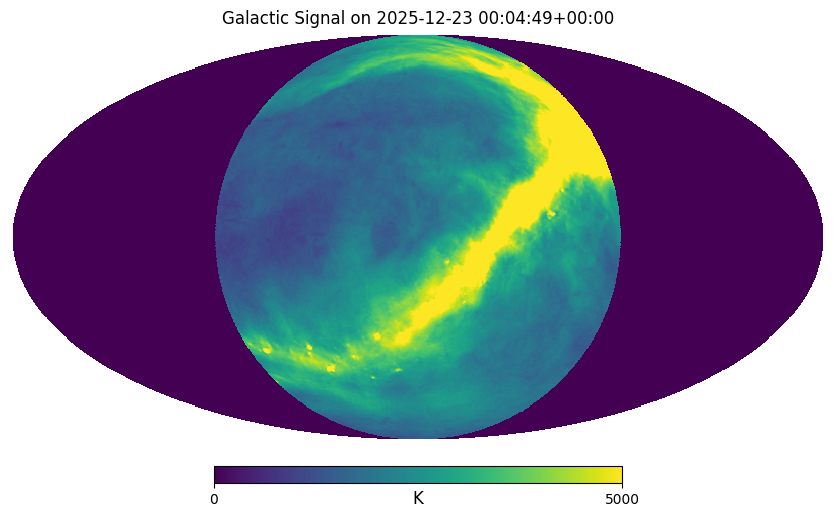

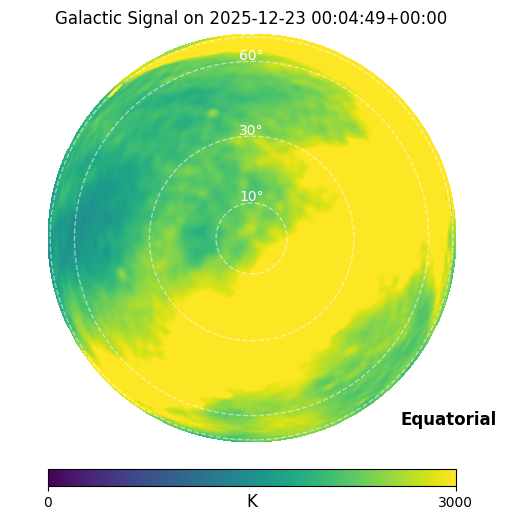

In [22]:
# Visualization (use Gnomonic for observer-centered view)
location = (test_site_latitude, test_site_longitude, test_site_elevation_meters)

hmap = generate_static_hp_map(frequency_mhz=70, 
                              utc_timestamp=antenna_timestamps[0], location=location,
                              observer='LFSM')

visualize_static_hmap(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}")
hp.mollview(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}", unit="K", max=5000)

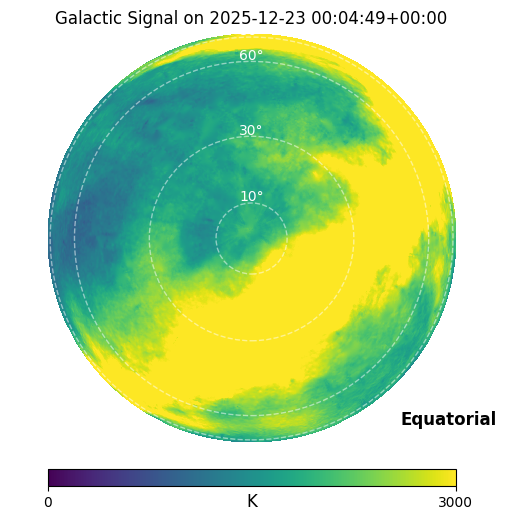

In [21]:
# Compare with Haslam map
hmap = generate_static_hp_map(70, antenna_timestamps[0], observer='Haslam', location=location)

visualize_static_hmap(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}")
hp.mollview(hmap, title=f"Galactic Signal on {antenna_timestamps[0]}", unit="K", max=5000)

### Load the beam pattern (effective heights)

In [125]:
# look at one example antenna gain pattern file
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import healpy as hp

gain_info = pd.read_csv(antenna_gain_pattern)

# Read what's included in the file
print("Antenna Gain Pattern Information:")
print(gain_info.head(2))

# Print a list of column names
print("------------------------------")
print("Column Names in Gain Pattern File:")
print(gain_info.columns)

gain_info['Voltage_Mag'] = (np.sqrt(gain_info['Voltage_Real (V)']**2 + gain_info['Voltage_Imag (V)']**2))

Antenna Gain Pattern Information:
   Frequency (Hz)  IncidentTheta (deg)  IncidentPhi (deg)  \
0        25000000                    0              11.25   
1        25000000                    2              11.25   

   Impedance_Real (Ohm)  Impedance_Imag (Ohm)  Voltage_Real (V)  \
0             301.60025           -877.298358         -0.000004   
1             301.60025           -877.298358         -0.015116   

   Voltage_Imag (V)  Current_Real (A)  Current_Imag (A)     Power (W)  
0          0.000006     -7.437934e-09     -1.927273e-09  8.902860e-15  
1          0.001534     -6.860747e-06     -1.487194e-05  4.045131e-08  
------------------------------
Column Names in Gain Pattern File:
Index(['Frequency (Hz)', 'IncidentTheta (deg)', 'IncidentPhi (deg)',
       'Impedance_Real (Ohm)', 'Impedance_Imag (Ohm)', 'Voltage_Real (V)',
       'Voltage_Imag (V)', 'Current_Real (A)', 'Current_Imag (A)',
       'Power (W)'],
      dtype='str')


In [126]:
# Check frequency values swept by the simulation   
unique_freqs = np.unique(gain_info['Frequency (Hz)'])
print(f"Unique frequencies in gain pattern file: {unique_freqs}")

# Check theta values swept by the simulation
unique_thetas = np.unique(gain_info['IncidentTheta (deg)'])
print(f"Unique theta values in gain pattern file: {unique_thetas}")

Unique frequencies in gain pattern file: [ 25000000  50000000  75000000 100000000 125000000 150000000 175000000
 200000000 225000000 250000000]
Unique theta values in gain pattern file: [ 0  2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46
 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90]


In [127]:
def load_gain_pattern(freq, gain_info):
    """
    Load the gain pattern for a specific frequency from the gain_info DataFrame.
    
    Parameters:
    freq (float): The frequency in Hz for which to load the gain pattern.
    gain_info (pd.DataFrame): DataFrame containing the gain information.
    
    Returns:
    theta (np.ndarray): Incident angles in degrees.
    gain (np.ndarray): 2D Gain map with (theta, phi) dimensions.
    """
    # Filter the DataFrame for the specified frequency
    freq_data = gain_info[gain_info['Frequency (Hz)'] == freq]
    
    # Extract theta and gain values
    theta = np.deg2rad(freq_data['IncidentTheta (deg)'].to_numpy())
    gain = freq_data['Voltage_Mag'].to_numpy().reshape((len(theta), 1)).repeat(181, axis=1)  # Using Voltage_Mag as a proxy for gain
    
    return theta, gain

In [128]:
def create_polar_plot(gain_thetas, gain_values, title='Basic Polar Plot'):
    """Creates a polar plot of the effective height at one phi slice.
    
    Parameters:
    - gain_values: 2D array of gain values with shape (num_theta, num_phi)"""
    # Create polar plot
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    # Set 0° at top, clockwise
    ax.set_theta_zero_location('N')  # 0 degrees = North (top)
    ax.set_theta_direction(-1)       # Clockwise direction
    ax.plot(gain_thetas, gain_values[:,0])  # Plot the first phi slice as an example

    plt.title(title)
    plt.show()

def generate_beam_map(frequency_mhz) -> np.ndarray:
    """
    Generate a beam map of the antenna for the given frequency using interpolation."""
    theta, gain_map = load_gain_pattern(frequency_mhz*1e6, gain_info)
    num_theta, num_phi = gain_map.shape
    theta1 = np.linspace(0, np.pi/2, num_theta)
    phi1 = np.linspace(0, 2*np.pi, num_phi)
    interpolator = RegularGridInterpolator(
        (theta1, phi1), gain_map,
        bounds_error=False, fill_value=0
    )
    beam_map = np.full(n_pix, 0.0)  # initialize with UNSEEN for masking
    # Get pixel centers in (θ, φ)
    theta_hp, phi_hp = hp.pix2ang(n_side, np.arange(n_pix))
    # Find pixels in upper hemisphere (θ <= π/2)
    mask_upper = theta_hp <= (np.pi / 2)
    # Prepare interpolation points only for those pixels
    interp_points = np.vstack((theta_hp[mask_upper], phi_hp[mask_upper])).T
    # Interpolate
    interp_values = interpolator(interp_points)
    # Assign to map (fill rest with UNSEEN or 0)
    beam_map[mask_upper] = interp_values
    rot = hp.Rotator([0, 90, 0])
    beam_map = rot.rotate_map_pixel(beam_map)
    return beam_map

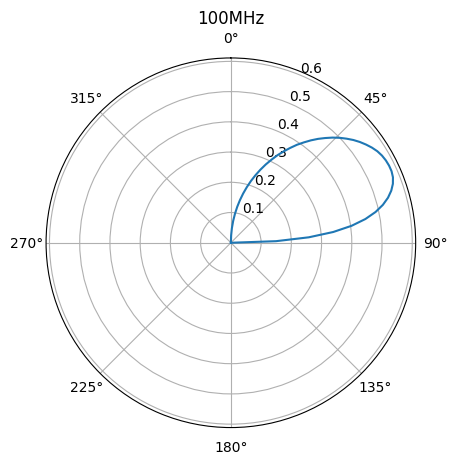

In [129]:
# Load and plot the gain pattern for 100 MHz
theta, gain = load_gain_pattern(100e6, gain_info)
create_polar_plot(theta, gain, title='100MHz')

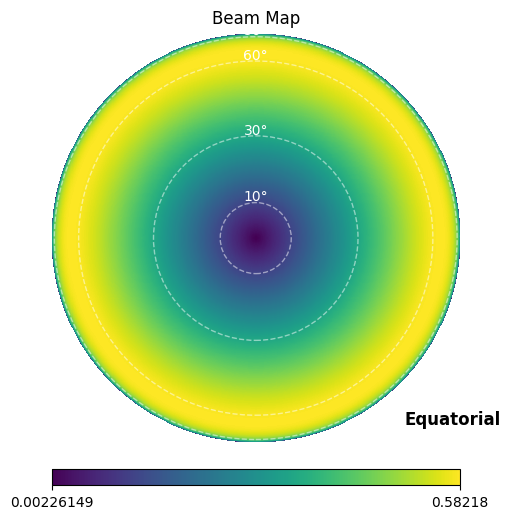

In [130]:
gain_phis = np.linspace(0, 2*np.pi, 181, endpoint=True)

beam_map = generate_beam_map(100)

def visualize_beam_map(beam_map):
    hp.orthview(beam_map, half_sky=True, coord='C', title="Beam Map")
    # Now add custom labels for azimuth and zenith angle
    ax = plt.gca()

    # Add concentric zenith angle circles (like elevation rings)
    zenith_angles = [10, 30, 60, 80]
    for za in zenith_angles:
        circle = plt.Circle((0, 0), np.sin(np.radians(za)), color='white', ls='--', fill=False, alpha=0.5)
        ax.add_artist(circle)
        plt.text(0, np.sin(np.radians(za)) + 0.01, f"{za}°", color='white', ha='center')

    # Add azimuth angle labels
    az_labels = [0, 90, 180, 270]
    label_pos = {
        0: (0, 1.05),       # North (up)
        90: (1.05, 0),      # East (right)
        180: (0, -1.1),     # South (down)
        270: (-1.1, 0),     # West (left)
    }
    for az in az_labels:
        x, y = label_pos[az]
        plt.text(x, y, f"{az}°", color='white', ha='center', va='center')

    plt.show()
visualize_beam_map(beam_map)

In [131]:
hp.mollview(beam_map)

In [ ]:
integrand = hmap * beam_map ** 2
hp.orthview(integrand, half_sky=True, coord='C', title="Beam Map", min=0, max=3000)
# Now add custom labels for azimuth and zenith angle
ax = plt.gca()

# Add concentric zenith angle circles (like elevation rings)
zenith_angles = [10, 30, 60, 80]
for za in zenith_angles:
    circle = plt.Circle((0, 0), np.sin(np.radians(za)), color='white', ls='--', fill=False, alpha=0.5)
    ax.add_artist(circle)
    plt.text(0, np.sin(np.radians(za)) + 0.01, f"{za}°", color='white', ha='center')

# Add azimuth angle labels
az_labels = [0, 90, 180, 270]
label_pos = {
    0: (0, 1.05),       # North (up)
    90: (1.05, 0),      # East (right)
    180: (0, -1.1),     # South (down)
    270: (-1.1, 0),     # West (left)
}
for az in az_labels:
    x, y = label_pos[az]
    plt.text(x, y, f"{az}°", color='white', ha='center', va='center')

plt.show()


### Recall

$$
T_A(\nu) = \frac{ \int_{\Omega} T_b(\theta, \phi, \nu) \, B(\theta, \phi, \nu) \, d\Omega }{ \int_{\Omega} B(\theta, \phi, \nu) \, d\Omega }
$$

This is how we will simulate the galactic signal, as seen by our antenna. Then we would attempt to subtract the galactic foreground from our data.

In [ ]:
def create_simulated_waterfall(utc_timestamps, frequencies_mhz):
    """
    Create a simulated waterfall of antenna data based on healpix maps and beam patterns"""
    simulated_antenna_data = np.zeros((len(utc_timestamps), len(frequencies_mhz)))
    for j, freq in enumerate(frequencies_mhz):
        beam_map = generate_beam_map(int(freq))
        D = np.sum(beam_map**2) * omega
        for i, timestamp in enumerate(utc_timestamps):
            hmap = generate_healpix_map(freq, timestamp)
            N = np.sum(hmap * beam_map ** 2) * omega
            #N = np.sum(hmap * beam_map) * omega
            simulated_antenna_data[i, j] = N#/D
            print(freq, timestamp, N)#/D)
    return simulated_antenna_data


#simulated_antenna_data = create_simulated_waterfall(new_utc_timestamps, gain_freqs)


simulated_antenna_data = create_simulated_waterfall(list([new_utc_timestamps[0],]), gain_freqs)

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(new_frequencies_mhz),5), labels=new_frequencies_mhz[::5])
plt.xlabel("MHz")
#plt.yticks(ticks=plot_timestamp_tick_idx, labels=plot_timestamp_tick_labels)
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data, vmin=1.5e2, vmax=3e4, aspect="auto")
_ = plt.colorbar()

In [ ]:
import skrf as rf
import numpy as np

ntwk = rf.Network('antenna4.s1p')
s11 = ntwk.s[:, 0, 0]   # shape (N,)

z0 = ntwk.z0[0]         # typically 50 ohms
nwk_frequencies = ntwk.f
impedance = z0 * (1 + s11) / (1 - s11)
real_impedance = np.real(impedance)
mismatch_loss = 1 - np.abs(s11)**2    # scalar between 0 and 1

from scipy.interpolate import interp1d

# Create interpolator
f = interp1d(nwk_frequencies/1e6, mismatch_loss, kind='cubic')  # kind can also be 'cubic', 'nearest', etc.
f2 = interp1d(nwk_frequencies/1e6, real_impedance, kind='cubic')  # kind can also be 'cubic', 'nearest', etc.
# Interpolate
new_mismatch_loss = f(gain_freqs)
new_real_impedence = f2(gain_freqs)
plt.plot(gain_freqs, new_mismatch_loss)



In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(gain_freqs)), labels=gain_freqs)
plt.xlabel("MHz")
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data*new_mismatch_loss, vmin=0, vmax=8e3, aspect="auto")
_ = plt.colorbar()

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=np.arange(0,len(gain_freqs)), labels=gain_freqs)
plt.xlabel("MHz")
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(simulated_antenna_data*new_mismatch_loss * (gain_freqs*1e6)**2/c**2 *377/(50*4)*(.49)**2, aspect="auto")
_ = plt.colorbar()

In [ ]:
plt.figure(1, figsize=(7,7), facecolor='white')
plt.xticks(ticks=plot_frequency_tick_idx, labels=plot_frequency_tick_labels)
plt.xlabel("MHz")
#plt.yticks(ticks=plot_timestamp_tick_idx, labels=plot_timestamp_tick_labels)
plt.ylabel("LST")
plt.title("Antenna Power Measured by the Spectrometer")

plt.imshow(antenna_calibrated, vmin=1.5e3, vmax=2.2e3, aspect="auto")
_ = plt.colorbar()

In [ ]:
gain_info = np.loadtxt("mimi_c49_antenna_gain.csv", delimiter=",", skiprows=2)
gain_freqs = np.arange(25, 250+25, 25)
gain_phis = np.deg2rad(gain_info[:,0])
gain_pattern = gain_info[:,1:].T
# Create polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set 0° at top, clockwise
ax.set_theta_zero_location('N')  # 0 degrees = North (top)
ax.set_theta_direction(-1)       # Clockwise direction
for idx, beam in enumerate(gain_pattern):
    ax.plot(gain_phis, beam, label=gain_freqs[idx])

ax.legend()
plt.show()

TODO:
1. Obtain the real antenna effective areas of each antenna - stop using the FEKO effective height (we are too close to obtaining real spectra to continue relying on FEKO simulation done in 2021 or something like that).
2. Go somewhere where there's less noise (obviously) - go to the frozen Canadian lake.
3. Change the data format of the spectra - transition from csv (or whatever the hell we're working with now) to FITS.


Hopefully these things will eliminate the "shabby" pipeline we're currently operating with, align the peak of the spectra obtained by the telescope to the pygdsm data, and actually unveil the 21 cm neutral hydrogen line that we've been looking for for 5+ years.
